<a href="https://colab.research.google.com/github/Hami-611/21Days_AI-ML_Challenge/blob/main/Day_8_CIFAR_100_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

### Apply the concepts and techniques learned in Fashion-MNIST project to the CIFAR-100 dataset. CIFAR-100 is a dataset consisting of 60,000 32x32 color images in 100 classes, with 600 images per class. There are 50,000 training images and 10,000 test images.

In [36]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

## 1) Dataset setup & EDA

In [37]:
print("Loading CIFAR-100 dataset...")
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

Loading CIFAR-100 dataset...


In [38]:
print("Shapes (raw):")
print(" x_train:", x_train.shape)
print(" y_train:", y_train.shape)
print(" x_test :", x_test.shape)
print(" y_test :", y_test.shape)

Shapes (raw):
 x_train: (50000, 32, 32, 3)
 y_train: (50000, 1)
 x_test : (10000, 32, 32, 3)
 y_test : (10000, 1)


In [39]:
num_classes = 100
input_shape = x_train.shape[1:]

In [40]:
# Normalize images to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

In [41]:

# One-hot encode labels
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat  = keras.utils.to_categorical(y_test, num_classes)

In [42]:
print("\nAfter preprocessing:")
print(" x_train:", x_train.shape, " dtype:", x_train.dtype)
print(" y_train_cat:", y_train_cat.shape)


After preprocessing:
 x_train: (50000, 32, 32, 3)  dtype: float32
 y_train_cat: (50000, 100)


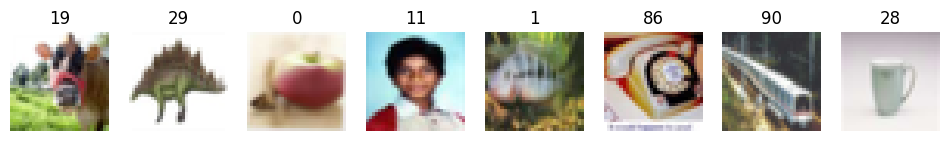

In [43]:
def show_samples(x, y, n=8):
    plt.figure(figsize=(12,3))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(x[i])
        plt.title(y[i].item())
        plt.axis('off')
    plt.show()

show_samples(x_train, y_train, n=8)

## 2) Model building

In [44]:
def build_ann(input_shape, num_classes):
    """Simple fully-connected ANN (for baseline)."""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [45]:
def build_cnn(input_shape, num_classes):
    """ConvNet designed to be reasonably deep but still trainable on CIFAR-size images."""
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.35),

        # Block 3
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        # Classifier head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [46]:
ann = build_ann(input_shape, num_classes)
cnn = build_cnn(input_shape, num_classes)

In [47]:
print("\nANN summary:")
ann.summary()


ANN summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,834,724 (14.63 MB)

 Trainable params: 3,831,652 (14.62 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [48]:
print("\nCNN summary:")
cnn.summary()


CNN summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,708,132 (10.33 MB)

 Trainable params: 2,706,212 (10.32 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 3) Compile & Callbacks

### Use Adam optimizer, categorical crossentropy loss.

### Use callbacks: EarlyStopping (patience), ReduceLROnPlateau, and ModelCheckpoint to save best models

In [49]:
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# callbacks
out_dir = './cifar100_models'
os.makedirs(out_dir, exist_ok=True)

In [50]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
ann_ckpt = callbacks.ModelCheckpoint(os.path.join(out_dir, 'ann_best.h5'), monitor='val_accuracy', save_best_only=True)
cnn_ckpt = callbacks.ModelCheckpoint(os.path.join(out_dir, 'cnn_best.h5'), monitor='val_accuracy', save_best_only=True)


## 4) Training


In [51]:
batch_size = 128
epochs = 35

data_augmentation = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

train_gen = data_augmentation.flow(x_train, y_train_cat, batch_size=batch_size)


In [52]:
history_cnn = cnn.fit(
    train_gen,
    epochs=epochs,
    validation_data=(x_test, y_test_cat),
    callbacks=[es, reduce_lr, cnn_ckpt],
    verbose=2
)

Epoch 1/35


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 - 47s - 120ms/step - accuracy: 0.0983 - loss: 4.2206 - val_accuracy: 0.0472 - val_loss: 4.6357 - learning_rate: 1.0000e-03
Epoch 2/35


391/391 - 32s - 82ms/step - accuracy: 0.1906 - loss: 3.4162 - val_accuracy: 0.2699 - val_loss: 2.9380 - learning_rate: 1.0000e-03
Epoch 3/35


391/391 - 30s - 78ms/step - accuracy: 0.2634 - loss: 2.9747 - val_accuracy: 0.2879 - val_loss: 2.9199 - learning_rate: 1.0000e-03
Epoch 4/35


391/391 - 31s - 79ms/step - accuracy: 0.3113 - loss: 2.6873 - val_accuracy: 0.2918 - val_loss: 2.9410 - learning_rate: 1.0000e-03
Epoch 5/35


391/391 - 30s - 78ms/step - accuracy: 0.3546 - loss: 2.5033 - val_accuracy: 0.3811 - val_loss: 2.3956 - learning_rate: 1.0000e-03
Epoch 6/35
391/391 - 31s - 80ms/step - accuracy: 0.3824 - loss: 2.3548 - val_accuracy: 0.3781 - val_loss: 2.3934 - learning_rate: 1.0000e-03
Epoch 7/35


391/391 - 30s - 78ms/step - accuracy: 0.4022 - loss: 2.2657 - val_accuracy: 0.3962 - val_loss: 2.4647 - learning_rate: 1.0000e-03
Epoch 8/35


391/391 - 43s - 110ms/step - accuracy: 0.4220 - loss: 2.1703 - val_accuracy: 0.4450 - val_loss: 2.0947 - learning_rate: 1.0000e-03
Epoch 9/35


391/391 - 30s - 77ms/step - accuracy: 0.4384 - loss: 2.0888 - val_accuracy: 0.4502 - val_loss: 2.1116 - learning_rate: 1.0000e-03
Epoch 10/35


391/391 - 31s - 79ms/step - accuracy: 0.4526 - loss: 2.0251 - val_accuracy: 0.4860 - val_loss: 1.9431 - learning_rate: 1.0000e-03
Epoch 11/35
391/391 - 31s - 78ms/step - accuracy: 0.4655 - loss: 1.9671 - val_accuracy: 0.4446 - val_loss: 2.1760 - learning_rate: 1.0000e-03
Epoch 12/35


391/391 - 32s - 82ms/step - accuracy: 0.4769 - loss: 1.9172 - val_accuracy: 0.4983 - val_loss: 1.8653 - learning_rate: 1.0000e-03
Epoch 13/35


391/391 - 32s - 81ms/step - accuracy: 0.4892 - loss: 1.8688 - val_accuracy: 0.4987 - val_loss: 1.9279 - learning_rate: 1.0000e-03
Epoch 14/35


391/391 - 32s - 82ms/step - accuracy: 0.4990 - loss: 1.8273 - val_accuracy: 0.5402 - val_loss: 1.7112 - learning_rate: 1.0000e-03
Epoch 15/35


391/391 - 31s - 79ms/step - accuracy: 0.5067 - loss: 1.7965 - val_accuracy: 0.5456 - val_loss: 1.6635 - learning_rate: 1.0000e-03
Epoch 16/35
391/391 - 42s - 108ms/step - accuracy: 0.5183 - loss: 1.7482 - val_accuracy: 0.5336 - val_loss: 1.7193 - learning_rate: 1.0000e-03
Epoch 17/35
391/391 - 31s - 79ms/step - accuracy: 0.5239 - loss: 1.7263 - val_accuracy: 0.5179 - val_loss: 1.8130 - learning_rate: 1.0000e-03
Epoch 18/35
391/391 - 32s - 81ms/step - accuracy: 0.5316 - loss: 1.6950 - val_accuracy: 0.5448 - val_loss: 1.6798 - learning_rate: 1.0000e-03
Epoch 19/35


391/391 - 31s - 80ms/step - accuracy: 0.5339 - loss: 1.6760 - val_accuracy: 0.5524 - val_loss: 1.6559 - learning_rate: 1.0000e-03
Epoch 20/35
391/391 - 31s - 80ms/step - accuracy: 0.5405 - loss: 1.6387 - val_accuracy: 0.5502 - val_loss: 1.6594 - learning_rate: 1.0000e-03
Epoch 21/35


391/391 - 32s - 83ms/step - accuracy: 0.5464 - loss: 1.6209 - val_accuracy: 0.5772 - val_loss: 1.5414 - learning_rate: 1.0000e-03
Epoch 22/35
391/391 - 31s - 79ms/step - accuracy: 0.5498 - loss: 1.6018 - val_accuracy: 0.5430 - val_loss: 1.6990 - learning_rate: 1.0000e-03
Epoch 23/35
391/391 - 32s - 81ms/step - accuracy: 0.5557 - loss: 1.5837 - val_accuracy: 0.5614 - val_loss: 1.6419 - learning_rate: 1.0000e-03
Epoch 24/35


391/391 - 31s - 80ms/step - accuracy: 0.5582 - loss: 1.5629 - val_accuracy: 0.5792 - val_loss: 1.5479 - learning_rate: 1.0000e-03
Epoch 25/35

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 - 32s - 82ms/step - accuracy: 0.5666 - loss: 1.5308 - val_accuracy: 0.5534 - val_loss: 1.6710 - learning_rate: 1.0000e-03
Epoch 26/35


391/391 - 31s - 80ms/step - accuracy: 0.5897 - loss: 1.4484 - val_accuracy: 0.5980 - val_loss: 1.4532 - learning_rate: 5.0000e-04
Epoch 27/35


391/391 - 32s - 82ms/step - accuracy: 0.5979 - loss: 1.4177 - val_accuracy: 0.6103 - val_loss: 1.4007 - learning_rate: 5.0000e-04
Epoch 28/35
391/391 - 33s - 85ms/step - accuracy: 0.6003 - loss: 1.3995 - val_accuracy: 0.6050 - val_loss: 1.4526 - learning_rate: 5.0000e-04
Epoch 29/35
391/391 - 31s - 80ms/step - accuracy: 0.6041 - loss: 1.3910 - val_accuracy: 0.5881 - val_loss: 1.5261 - learning_rate: 5.0000e-04
Epoch 30/35


391/391 - 32s - 83ms/step - accuracy: 0.6079 - loss: 1.3705 - val_accuracy: 0.6104 - val_loss: 1.3953 - learning_rate: 5.0000e-04
Epoch 31/35


391/391 - 31s - 80ms/step - accuracy: 0.6101 - loss: 1.3636 - val_accuracy: 0.6124 - val_loss: 1.4258 - learning_rate: 5.0000e-04
Epoch 32/35
391/391 - 32s - 82ms/step - accuracy: 0.6116 - loss: 1.3562 - val_accuracy: 0.6057 - val_loss: 1.4580 - learning_rate: 5.0000e-04
Epoch 33/35
391/391 - 31s - 80ms/step - accuracy: 0.6134 - loss: 1.3461 - val_accuracy: 0.5862 - val_loss: 1.5761 - learning_rate: 5.0000e-04
Epoch 34/35

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
391/391 - 41s - 106ms/step - accuracy: 0.6156 - loss: 1.3341 - val_accuracy: 0.6057 - val_loss: 1.4339 - learning_rate: 5.0000e-04
Epoch 35/35


391/391 - 31s - 80ms/step - accuracy: 0.6268 - loss: 1.2951 - val_accuracy: 0.6146 - val_loss: 1.4091 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 30.


## 5) Evaluation & Plots

### Plot training/validation loss and accuracy to check overfitting.

Confusion matrix + classification report for per-class metrics. Because there are 100 classes, the confusion matrix is big; you can inspect slices or aggregate metrics.

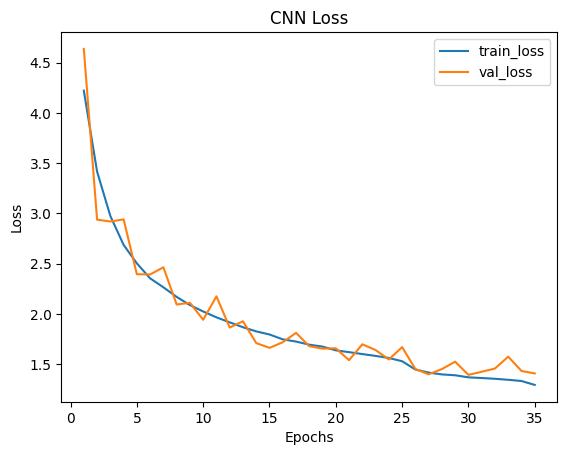

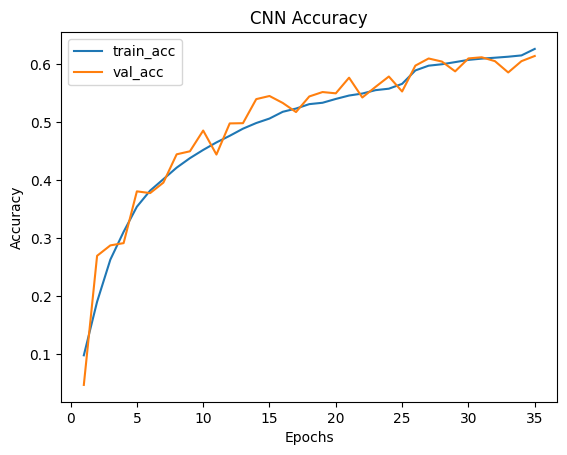

313/313 - 1s - 4ms/step - accuracy: 0.6104 - loss: 1.3953
CNN test loss, test acc: [1.3952783346176147, 0.6104000210762024]


In [53]:
def plot_history(history, prefix='Model'):
    h = history.history
    epochs = range(1, len(h['loss']) + 1)

    plt.figure()
    plt.plot(epochs, h['loss'], label='train_loss')
    if 'val_loss' in h:
        plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.title(prefix + ' Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, h['accuracy'], label='train_acc')
    if 'val_accuracy' in h:
        plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.title(prefix + ' Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_cnn, 'CNN')

cnn_eval = cnn.evaluate(x_test, y_test_cat, verbose=2)
print("CNN test loss, test acc:", cnn_eval)

##  6) Confusion Matrix + Classification Report

In [54]:
y_pred_probs = cnn.predict(x_test, batch_size=256)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Confusion matrix shape: (100, 100)


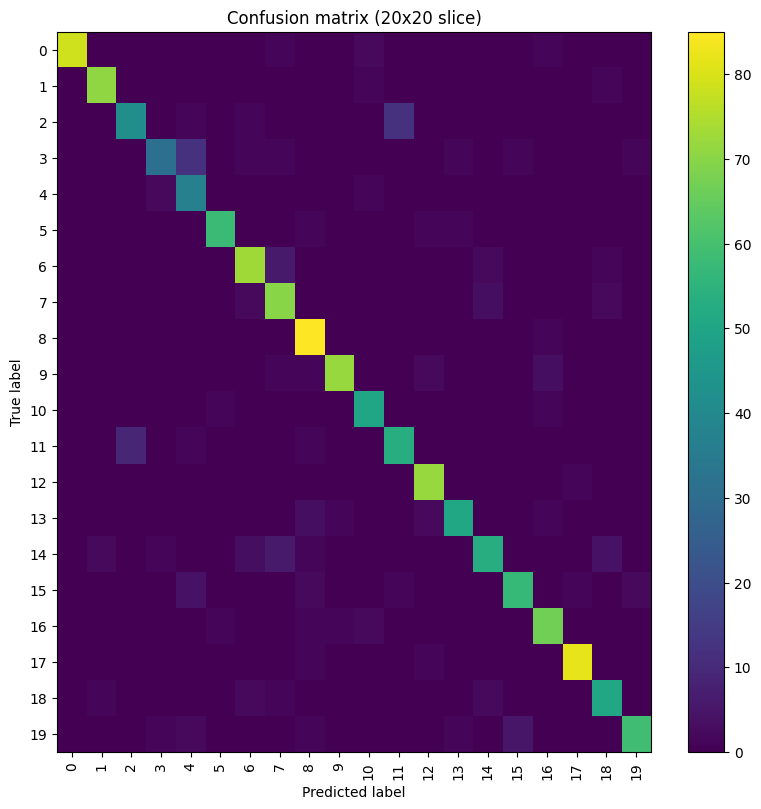

In [55]:
def plot_confusion_matrix(cm, classes=None, normalize=False, title='Confusion matrix (slice)'):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
    # For readability, show 20x20 slice or full if you prefer. Here we show the top-left 20x20 slice.
    slice_n = min(20, cm.shape[0])
    cm_slice = cm[:slice_n, :slice_n]
    plt.figure(figsize=(8,8))
    plt.imshow(cm_slice, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(slice_n)
    plt.xticks(tick_marks, tick_marks, rotation=90)
    plt.yticks(tick_marks, tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, normalize=False, title='Confusion matrix (20x20 slice)')

In [56]:
# Classification report (very large — contains per-class metrics)
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()

In [57]:
# Print overall metrics summary:
print(report_df.loc[['accuracy','macro avg','weighted avg']])

              precision  recall  f1-score     support
accuracy       0.610400  0.6104  0.610400      0.6104
macro avg      0.641109  0.6104  0.610829  10000.0000
weighted avg   0.641109  0.6104  0.610829  10000.0000


In [58]:
# Save models for later analysis
cnn.save(os.path.join(out_dir, 'cnn_final.h5'))

## 7) Prediction Analysis

### Visualize some misclassified samples to understand class confusion, often useful for small image sizes where classes are visually similar.

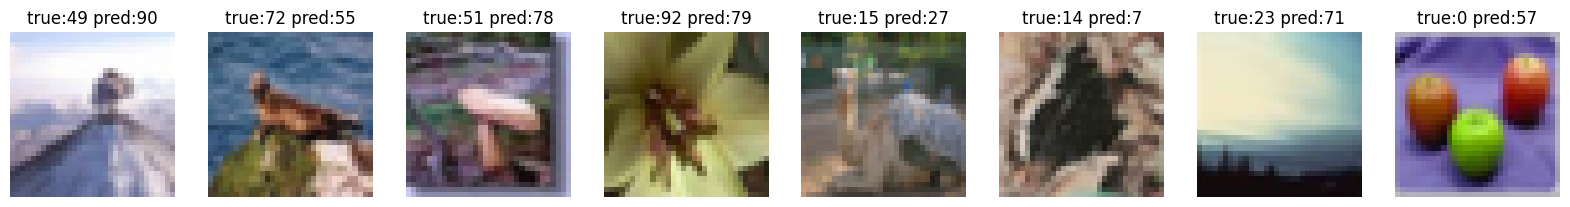

In [59]:
def show_predictions(x, y_true, y_pred, n=8):
    plt.figure(figsize=(20,3))
    shown = 0
    i = 0
    while shown < n and i < len(x):
        if y_true[i] != y_pred[i]:
            plt.subplot(1,n,shown+1)
            plt.imshow(x[i])
            plt.title(f"true:{y_true[i]} pred:{y_pred[i]}")
            plt.axis('off')
            shown += 1
        i += 1
    if shown == 0:
        print("No misclassified examples in first slice — try increasing search range.")
    else:
        plt.show()

show_predictions(x_test, y_true, y_pred, n=8)

## Results and Analysis (CNN Model)

Analyzing the confusion matrix (slice) and the misclassified samples reveals some insights into the model's performance:

*   **Confusion Matrix**: The diagonal elements of the confusion matrix show the number of correct predictions for each class within the displayed slice. Off-diagonal elements indicate misclassifications between classes. Observing the slice, we can see where the model is performing well and where it is struggling with specific class distinctions.
*   **Classification Report**: The classification report provides detailed per-class metrics (precision, recall, f1-score) and overall averages. The macro average and weighted average provide a summary of the model's performance across all 100 classes.
*   **Misclassified Samples**: Visualizing misclassified samples helps understand the types of errors the model makes. For example, visually similar classes might be more prone to confusion. The small image size of CIFAR-100 likely contributes to difficulty in distinguishing fine-grained differences between some classes, leading to misclassifications.

## Project Summary

This notebook demonstrates a classification task on the CIFAR-100 dataset.

1.  **Dataset Setup & EDA**: The CIFAR-100 dataset was loaded, examined for its shape and data types, and preprocessed by normalizing pixel values and one-hot encoding the labels. A function to display sample images was also defined and used.
2.  **Model Building**: Two models were built: a simple Artificial Neural Network (ANN) and a Convolutional Neural Network (CNN). The architecture and parameters of both models were summarized.
3.  **Compile & Callbacks**: Both models were compiled using the Adam optimizer and categorical crossentropy loss. Callbacks for Early Stopping, ReduceLROnPlateau, and Model Checkpointing were set up.
4.  **Training**: The CNN model was trained using an ImageDataGenerator for data augmentation. The training progress was displayed.
5.  **Evaluation & Plots**: The training and validation loss and accuracy for the CNN model were plotted. The model was evaluated on the test set.
6.  **Confusion Matrix + Classification Report**: A confusion matrix and classification report were generated for the CNN model's predictions on the test set. The overall metrics were printed.
7.  **Prediction Analysis**: A function to display misclassified samples was defined and used to visualize some examples of incorrect predictions by the CNN model.